In [1]:

import pandas as pd

data = pd.read_csv(r"C:\Users\GOWRISHANKAR\online_retails.csv")
print(data.head())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [2]:
print(data.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [3]:
print(data.shape)

(1067371, 8)


In [4]:
print(data.tail)

<bound method NDFrame.tail of         Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
1067366  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
1067368  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
1067369  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
1067370  581587      POST                              POSTAGE         1   

                 InvoiceDate  Price  Customer ID         

In [6]:
"""
customer_segmentation_end2end.py
End-to-end Customer Segmentation (RFM + KMeans)
This version expects your dataset named 'online_retails.csv' or 'online_retails.xlsx'
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings("ignore")

# ---------- CONFIG ----------
BASE_NAME = "online_retails"     # <--- your file base name (no extension)
CSV_PATH = BASE_NAME + ".csv"
XLSX_PATH = BASE_NAME + ".xlsx"
OUTPUT_CLEAN = "cleaned_online_retail.csv"
RFM_CSV = "rfm_features.csv"
OUTPUT_CLUSTERS = "customers_with_clusters.csv"
PLOT_PCA = "cluster_plot.png"
PIPELINE_FILE = "preprocessor_and_model.joblib"
RANDOM_STATE = 42

def load_and_clean():
    # load csv if exists else try excel
    import os
    if os.path.exists(CSV_PATH):
        print("Loading", CSV_PATH)
        df = pd.read_csv(CSV_PATH, dtype=str)
    elif os.path.exists(XLSX_PATH):
        print("Loading", XLSX_PATH)
        df = pd.read_excel(XLSX_PATH, dtype=str)
    else:
        raise FileNotFoundError(f"Neither {CSV_PATH} nor {XLSX_PATH} found in current folder.")
    # strip column names
    df.columns = [c.strip() for c in df.columns]
    # common renames
    if 'CustomerID' in df.columns and 'Customer ID' not in df.columns:
        df = df.rename(columns={'CustomerID':'Customer ID'})
    # ensure important columns exist
    if not any(col in df.columns for col in ['InvoiceDate','Invoice Date']):
        raise ValueError("Missing 'InvoiceDate' column (or 'Invoice Date').")
    # normalize date column
    if 'InvoiceDate' in df.columns:
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    else:
        df['InvoiceDate'] = pd.to_datetime(df['Invoice Date'], errors='coerce')
    # Customer ID
    if 'Customer ID' in df.columns:
        df['Customer ID'] = df['Customer ID'].astype(str).str.strip()
    elif 'CustomerID' in df.columns:
        df['Customer ID'] = df['CustomerID'].astype(str).str.strip()
    else:
        raise ValueError("Missing customer id column. Expected 'Customer ID' or 'CustomerID'.")
    # Quantity -> numeric
    for qcol in ['Quantity','Qty']:
        if qcol in df.columns:
            df['Quantity'] = pd.to_numeric(df[qcol], errors='coerce').fillna(0)
            break
    if 'Quantity' not in df.columns:
        raise ValueError("Missing 'Quantity' column.")
    # Price column (Price / UnitPrice / Unit Price)
    price_col = None
    for candidate in ['Price','UnitPrice','Unit Price','Unit price']:
        if candidate in df.columns:
            price_col = candidate
            break
    if price_col is None:
        # try to find any numeric column that looks like price
        numeric_candidates = df.select_dtypes(include=['float','int','object']).columns.tolist()
        price_col = None
    else:
        df['Price'] = pd.to_numeric(df[price_col], errors='coerce').fillna(0)
    # Remove rows with no customer id or invalid dates
    df = df.dropna(subset=['Customer ID'])
    df = df[~df['InvoiceDate'].isna()].copy()
    # Remove returns / negative qty
    df = df[df['Quantity'] > 0].copy()
    # Create TotalPrice
    df['TotalPrice'] = df['Quantity'] * df['Price']
    # Keep commonly useful columns if present
    keep = ['Customer ID','InvoiceDate','Invoice','Quantity','TotalPrice']
    for c in ['Country','Description','StockCode','Price']:
        if c in df.columns and c not in keep:
            keep.append(c)
    df = df.loc[:, [c for c in keep if c in df.columns]]
    df = df.reset_index(drop=True)
    print("Rows after cleaning:", len(df))
    df.to_csv(OUTPUT_CLEAN, index=False)
    print("Saved cleaned ->", OUTPUT_CLEAN)
    return df

def create_rfm(df, days_window=None):
    print("Computing RFM features...")
    if days_window:
        recent_cutoff = df['InvoiceDate'].max() - pd.Timedelta(days=days_window)
        df = df[df['InvoiceDate'] >= recent_cutoff].copy()
        print(f"Filtered last {days_window} days -> rows:", len(df))
    reference_date = df['InvoiceDate'].max() + timedelta(days=1)
    agg = df.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'Invoice': 'nunique',
        'TotalPrice': 'sum'
    }).rename(columns={'InvoiceDate':'Recency','Invoice':'Frequency','TotalPrice':'Monetary'})
    agg = agg[agg['Monetary'] > 0].reset_index()
    agg['Monetary_log'] = np.log1p(agg['Monetary'])
    agg.to_csv(RFM_CSV, index=False)
    print("Saved RFM ->", RFM_CSV)
    return agg

def pick_k_and_cluster(X, ks=range(2,11)):
    best_k = None
    best_score = -1
    scores = {}
    for k in ks:
        km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=1024)
        labels = km.fit_predict(X)
        if len(np.unique(labels)) < 2:
            sil = -1
        else:
            sil = silhouette_score(X, labels)
        scores[k] = sil
        print(f"k={k} silhouette={sil:.4f}")
        if sil > best_score:
            best_score = sil; best_k = k
    print("Chosen k:", best_k, "silhouette:", best_score)
    final_km = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE, batch_size=1024)
    labels = final_km.fit_predict(X)
    return final_km, labels, scores

def profile_clusters(rfm_df):
    print("\nCluster profile (median & count):")
    num = ['Recency','Frequency','Monetary']
    profile = rfm_df.groupby('Cluster')[num].agg(['count','median','mean']).round(2)
    print(profile)
    return profile

def main():
    df = load_and_clean()
    rfm = create_rfm(df, days_window=None)
    features = rfm[['Recency','Frequency','Monetary_log']].copy()
    scaler = StandardScaler()
    X = scaler.fit_transform(features)
    model, labels, scores = pick_k_and_cluster(X, ks=range(2,11))
    rfm['Cluster'] = labels
    rfm.to_csv(OUTPUT_CLUSTERS, index=False)
    print("Saved clusters ->", OUTPUT_CLUSTERS)
    profile_clusters(rfm)
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=rfm['Cluster'], palette='tab10', s=12, legend='full')
    plt.title("Customer segments (PCA 2D)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(PLOT_PCA, dpi=150)
    plt.close()
    print("Saved PCA plot ->", PLOT_PCA)
    saved = {'scaler': scaler, 'pca': pca, 'kmeans': model, 'features': ['Recency','Frequency','Monetary_log']}
    joblib.dump(saved, PIPELINE_FILE)
    print("Saved pipeline ->", PIPELINE_FILE)
    print("\nDone. Outputs:")
    print(" -", OUTPUT_CLEAN)
    print(" -", RFM_CSV)
    print(" -", OUTPUT_CLUSTERS)
    print(" -", PLOT_PCA)
    print(" -", PIPELINE_FILE)

if __name__ == "__main__":
    main()


Loading online_retails.csv
Rows after cleaning: 1044421
Saved cleaned -> cleaned_online_retail.csv
Computing RFM features...
Saved RFM -> rfm_features.csv
k=2 silhouette=0.4533
k=3 silhouette=0.4150
k=4 silhouette=0.3851
k=5 silhouette=0.3878
k=6 silhouette=0.3749
k=7 silhouette=0.3670
k=8 silhouette=0.3523
k=9 silhouette=0.3712
k=10 silhouette=0.3511
Chosen k: 2 silhouette: 0.45332154659189916
Saved clusters -> customers_with_clusters.csv

Cluster profile (median & count):
        Recency                Frequency               Monetary           \
          count median    mean     count median   mean    count   median   
Cluster                                                                    
0          3348   33.0   62.42      3348    6.0  11.08     3348  1879.50   
1          2531  396.0  385.01      2531    1.0   1.92     2531   317.08   

                  
            mean  
Cluster           
0        5836.26  
1         503.55  
Saved PCA plot -> cluster_plot.png
Saved pipe

In [7]:
# Cell 1: imports & load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import numpy as np
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# load data
df = pd.read_csv("customers_with_clusters.csv")

# ensure numeric types
for col in ["Recency","Frequency","Monetary"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

display(Markdown("## Loaded dataset — top 5 rows"))
display(df.head())


## Loaded dataset — top 5 rows

,Customer ID,Recency,Frequency,Monetary,Monetary_log,Cluster
0,12346.0,326,12,77556.46,11.258774,0
1,12347.0,2,8,5633.32,8.636632,0
2,12348.0,75,5,2019.40,7.611051,0
3,12349.0,19,4,4428.69,8.396085,0
4,12350.0,310,1,334.40,5.815324,1


In [8]:
# Cell 2: helper functions to show heading and save & show plot
import os

os.makedirs("plots", exist_ok=True)

def show_heading(text, level=3):
    display(Markdown(f"{'#'*level} {text}"))

def save_and_show(fig, fname, tight=True):
    path = os.path.join("plots", fname)
    if tight:
        fig.tight_layout()
    fig.savefig(path, dpi=150)
    print("Saved:", path)
    plt.show()


### 1. Cluster Counts

Saved: plots\plot1_cluster_counts.png


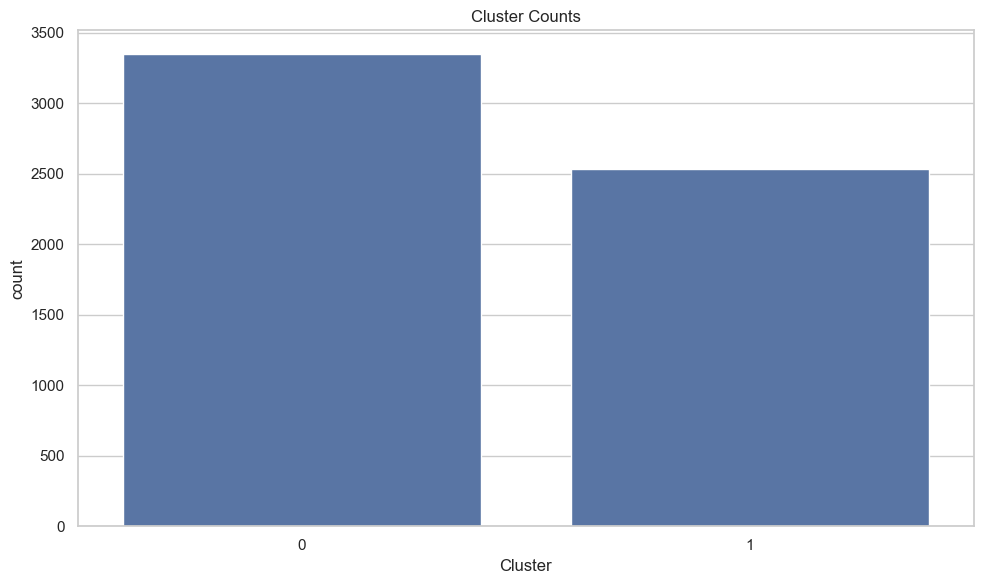

### 2. Recency Distribution

Saved: plots\plot2_recency_distribution.png


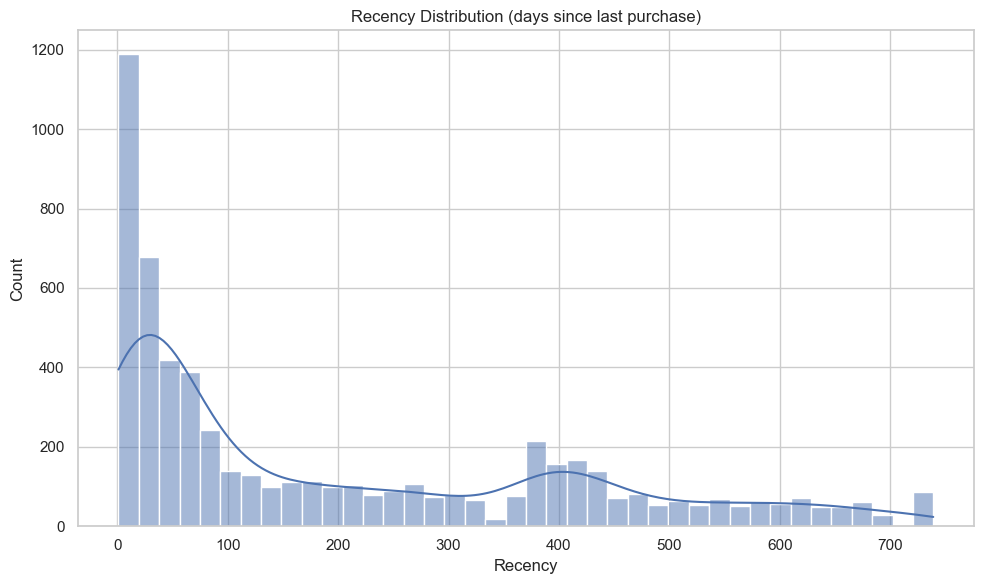

### 3. Frequency Distribution

Saved: plots\plot3_frequency_distribution.png


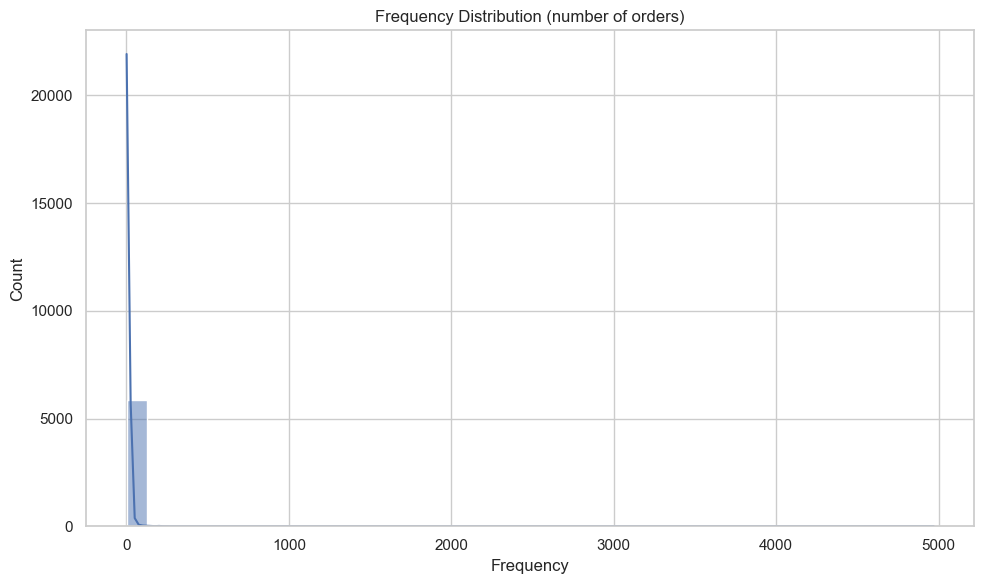

### 4. Monetary Distribution

Saved: plots\plot4_monetary_distribution.png


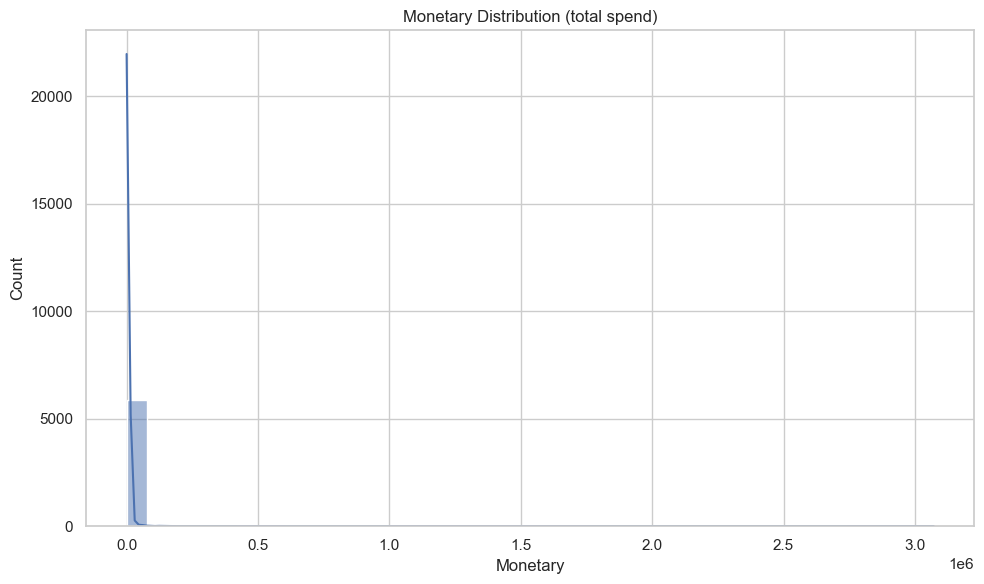

### 5. Recency by Cluster

Saved: plots\plot5_recency_by_cluster.png


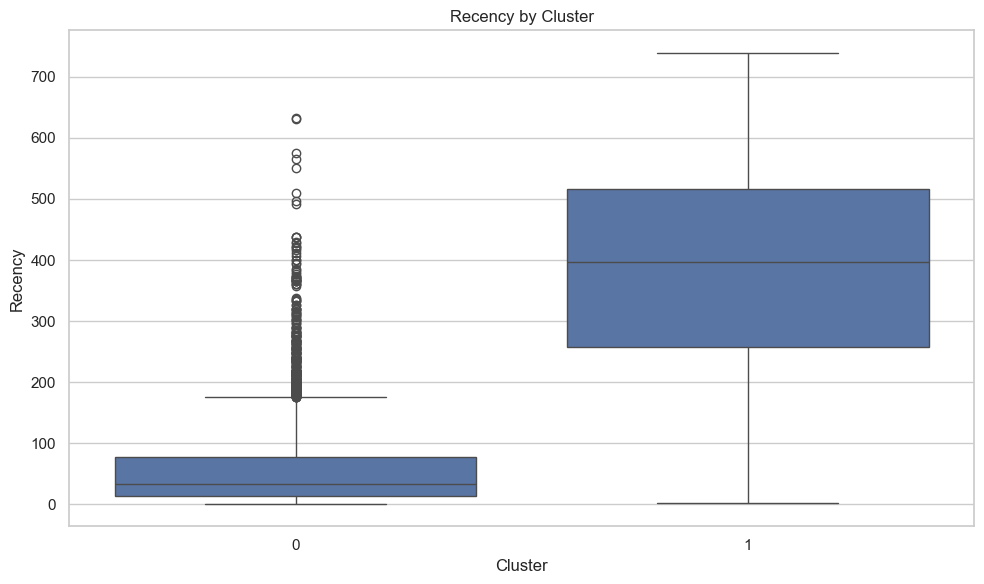

### 6. Frequency by Cluster

Saved: plots\plot6_frequency_by_cluster.png


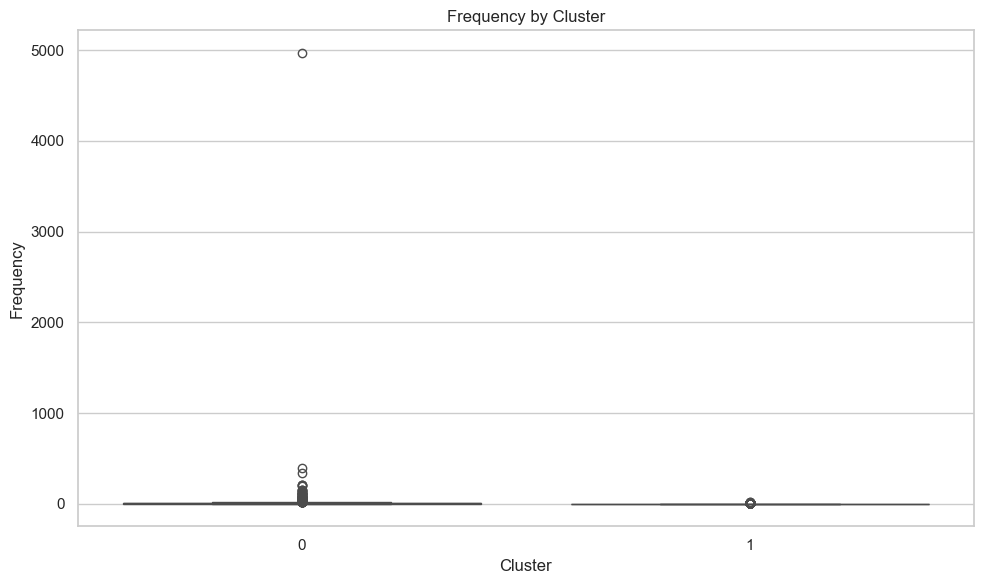

### 7. Monetary vs Frequency (cluster colored)

Saved: plots\plot7_monetary_vs_frequency.png


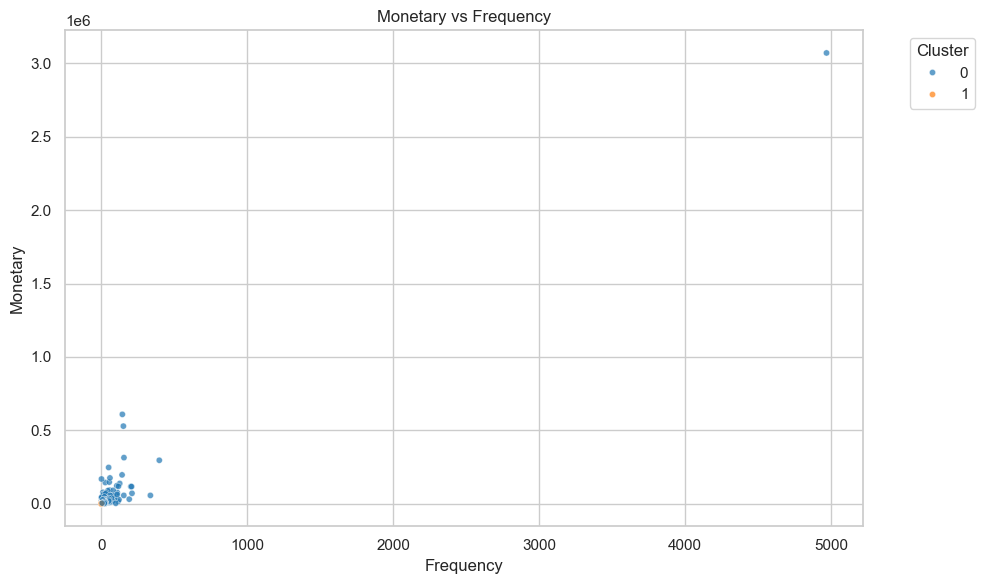

### 8. Correlation Heatmap (RFM)

Saved: plots\plot8_corr_heatmap.png


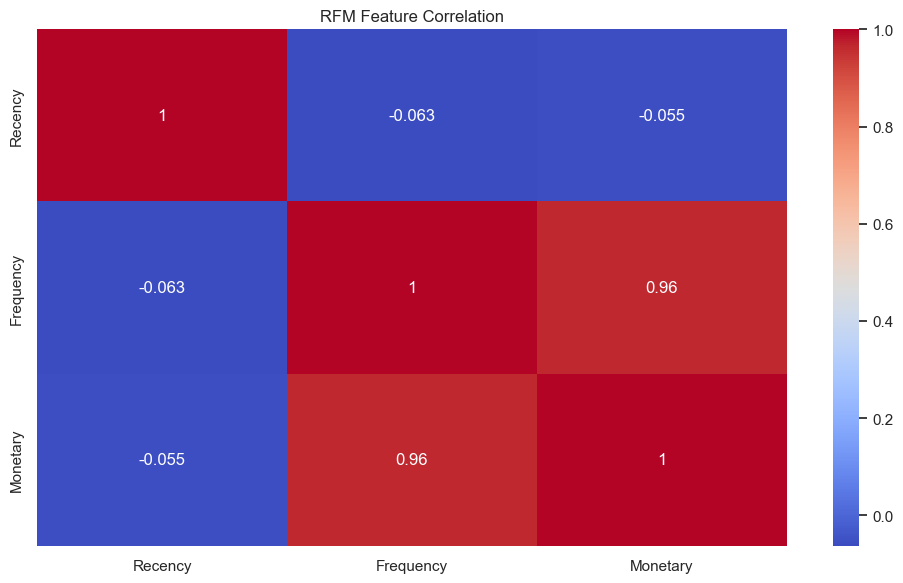

### 9. Monetary by Cluster (log scale)

Saved: plots\plot9_monetary_by_cluster.png


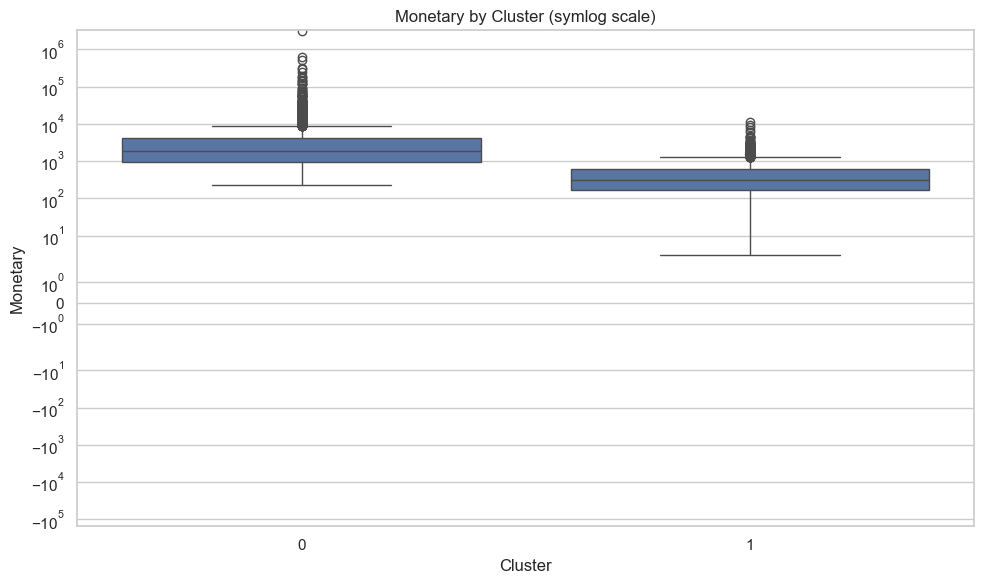

### 10. RFM Pairplot (sampled)

Saved: plots\plot10_rfm_pairplot.png


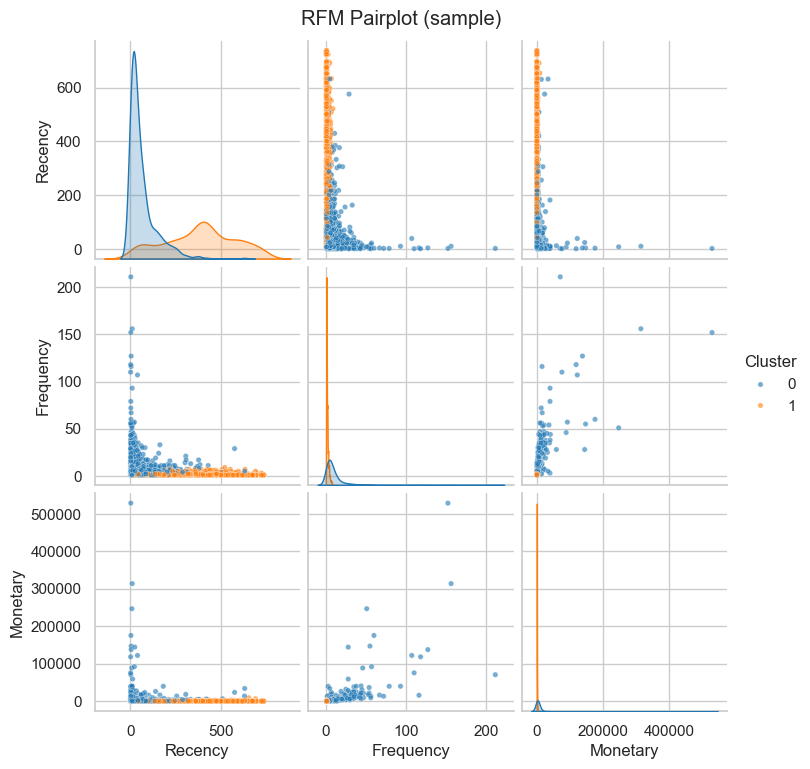

In [9]:
# Cell 3: create & show each plot with its own heading, save separately

# 1) Cluster Count Plot
show_heading("1. Cluster Counts")
fig, ax = plt.subplots()
sns.countplot(x=df["Cluster"], ax=ax)
ax.set_title("Cluster Counts")
save_and_show(fig, "plot1_cluster_counts.png")

# 2) Recency Distribution
show_heading("2. Recency Distribution")
fig, ax = plt.subplots()
sns.histplot(df["Recency"].dropna(), bins=40, kde=True, ax=ax)
ax.set_title("Recency Distribution (days since last purchase)")
save_and_show(fig, "plot2_recency_distribution.png")

# 3) Frequency Distribution
show_heading("3. Frequency Distribution")
fig, ax = plt.subplots()
sns.histplot(df["Frequency"].dropna(), bins=40, kde=True, ax=ax)
ax.set_title("Frequency Distribution (number of orders)")
save_and_show(fig, "plot3_frequency_distribution.png")

# 4) Monetary Distribution
show_heading("4. Monetary Distribution")
fig, ax = plt.subplots()
sns.histplot(df["Monetary"].dropna(), bins=40, kde=True, ax=ax)
ax.set_title("Monetary Distribution (total spend)")
save_and_show(fig, "plot4_monetary_distribution.png")

# 5) Recency by Cluster (boxplot)
show_heading("5. Recency by Cluster")
fig, ax = plt.subplots()
sns.boxplot(x="Cluster", y="Recency", data=df, ax=ax)
ax.set_title("Recency by Cluster")
save_and_show(fig, "plot5_recency_by_cluster.png")

# 6) Frequency by Cluster (boxplot)
show_heading("6. Frequency by Cluster")
fig, ax = plt.subplots()
sns.boxplot(x="Cluster", y="Frequency", data=df, ax=ax)
ax.set_title("Frequency by Cluster")
save_and_show(fig, "plot6_frequency_by_cluster.png")

# 7) Monetary vs Frequency (scatter)
show_heading("7. Monetary vs Frequency (cluster colored)")
fig, ax = plt.subplots()
sns.scatterplot(x="Frequency", y="Monetary", hue="Cluster", data=df, palette="tab10", ax=ax, s=20, alpha=0.7)
ax.set_title("Monetary vs Frequency")
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
save_and_show(fig, "plot7_monetary_vs_frequency.png")

# 8) Correlation Heatmap
show_heading("8. Correlation Heatmap (RFM)")
fig, ax = plt.subplots()
sns.heatmap(df[["Recency","Frequency","Monetary"]].corr(), annot=True, cmap="coolwarm", ax=ax)
ax.set_title("RFM Feature Correlation")
save_and_show(fig, "plot8_corr_heatmap.png")

# 9) Monetary by Cluster (boxplot, log scale)
show_heading("9. Monetary by Cluster (log scale)")
fig, ax = plt.subplots()
sns.boxplot(x="Cluster", y="Monetary", data=df, ax=ax)
ax.set_yscale("symlog")  # symmetrical log helps with zeros/outliers
ax.set_title("Monetary by Cluster (symlog scale)")
save_and_show(fig, "plot9_monetary_by_cluster.png")

# 10) RFM Pairplot (sampled if large)
show_heading("10. RFM Pairplot (sampled)")
sample = df.sample(n=min(2000, len(df)), random_state=42)  # limit size for speed
pairplot = sns.pairplot(sample[["Recency","Frequency","Monetary","Cluster"]], hue="Cluster", palette="tab10", diag_kind="kde", plot_kws={'s':15, 'alpha':0.6})
pairplot.fig.suptitle("RFM Pairplot (sample)", y=1.02)
pairplot.savefig(os.path.join("plots","plot10_rfm_pairplot.png"))
print("Saved:", os.path.join("plots","plot10_rfm_pairplot.png"))
plt.show()


## Combined figure — All 10 plots (2 rows × 5 cols)

Saved combined figure: plots/combined_10_plots.png


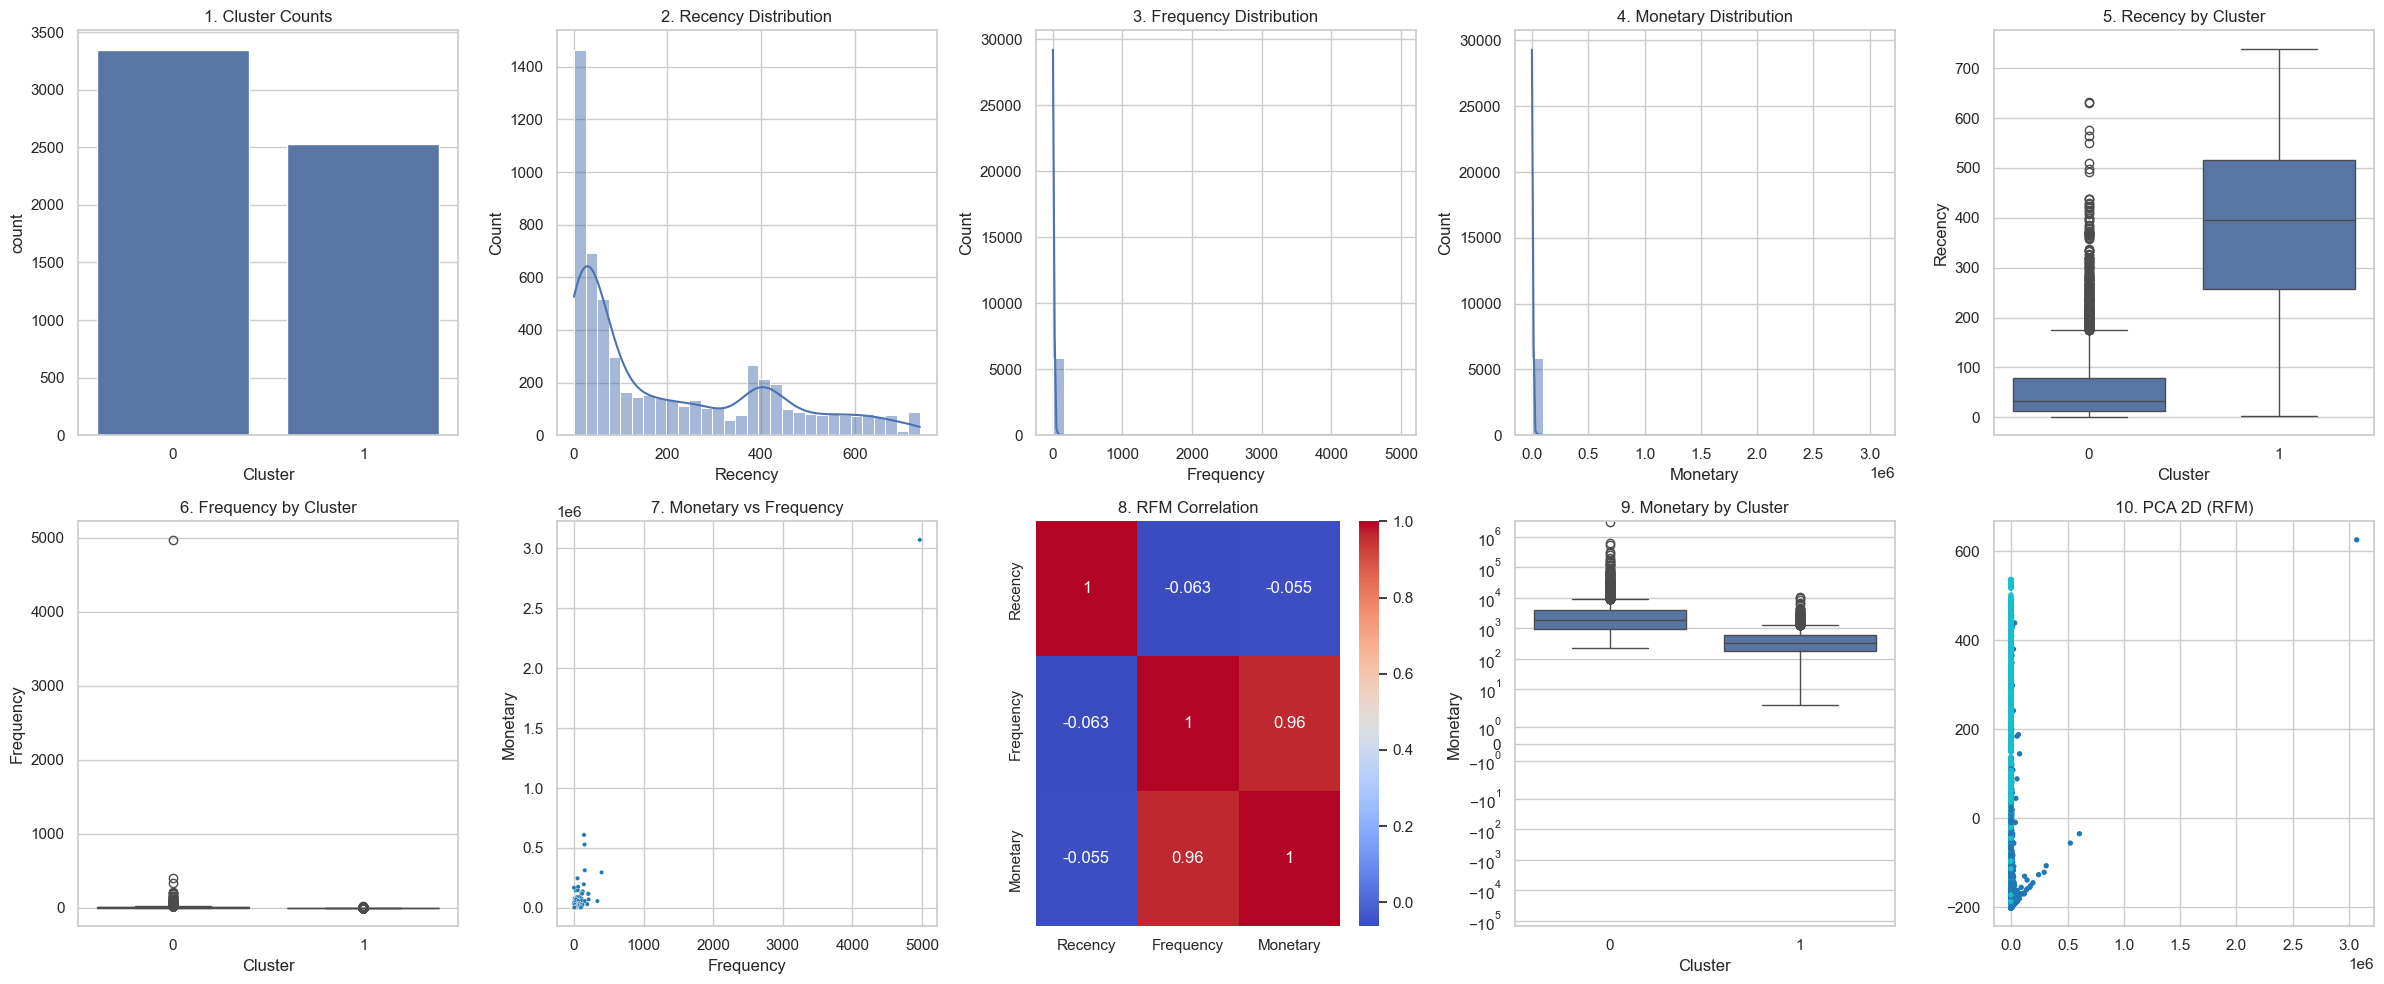

In [10]:

# Cell 4: create a combined figure with all 10 plots in a 2x5 grid
show_heading("Combined figure — All 10 plots (2 rows × 5 cols)", level=2)

fig, axes = plt.subplots(2,5, figsize=(24,10))
axes = axes.flatten()

# A small helper to draw on axes instead of creating new figures
sns.countplot(x=df["Cluster"], ax=axes[0])
axes[0].set_title("1. Cluster Counts")

sns.histplot(df["Recency"].dropna(), bins=30, kde=True, ax=axes[1])
axes[1].set_title("2. Recency Distribution")

sns.histplot(df["Frequency"].dropna(), bins=30, kde=True, ax=axes[2])
axes[2].set_title("3. Frequency Distribution")

sns.histplot(df["Monetary"].dropna(), bins=30, kde=True, ax=axes[3])
axes[3].set_title("4. Monetary Distribution")

sns.boxplot(x="Cluster", y="Recency", data=df, ax=axes[4])
axes[4].set_title("5. Recency by Cluster")

sns.boxplot(x="Cluster", y="Frequency", data=df, ax=axes[5])
axes[5].set_title("6. Frequency by Cluster")

sns.scatterplot(x="Frequency", y="Monetary", hue="Cluster", data=df, palette="tab10", ax=axes[6], s=10, legend=False)
axes[6].set_title("7. Monetary vs Frequency")

sns.heatmap(df[["Recency","Frequency","Monetary"]].corr(), annot=True, cmap="coolwarm", ax=axes[7])
axes[7].set_title("8. RFM Correlation")

sns.boxplot(x="Cluster", y="Monetary", data=df, ax=axes[8])
axes[8].set_yscale("symlog")
axes[8].set_title("9. Monetary by Cluster")

# PCA 2D for last subplot (10)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df[["Recency","Frequency","Monetary"]].fillna(0).values)
axes[9].scatter(X_pca[:,0], X_pca[:,1], c=df["Cluster"], cmap="tab10", s=8)
axes[9].set_title("10. PCA 2D (RFM)")

plt.tight_layout()
combined_path = "plots/combined_10_plots.png"
fig.savefig(combined_path, dpi=180)
print("Saved combined figure:", combined_path)
plt.show()


In [11]:
import os

# Create folder for plots
os.makedirs("plots", exist_ok=True)

print("Folder created:", os.path.abspath("plots"))


Folder created: C:\Users\GOWRISHANKAR\plots


In [13]:
def save_and_show(fig, filename):
    path = f"plots/{filename}"
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    print("Saved:", path)
    plt.show()


Saved: plots/cluster_count.png


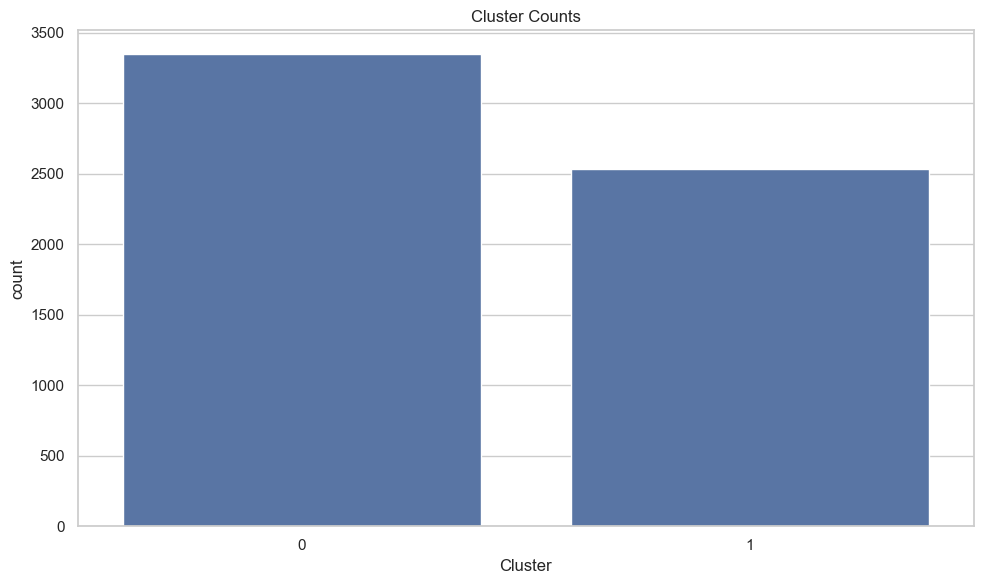

Saved: plots/recency_distribution.png


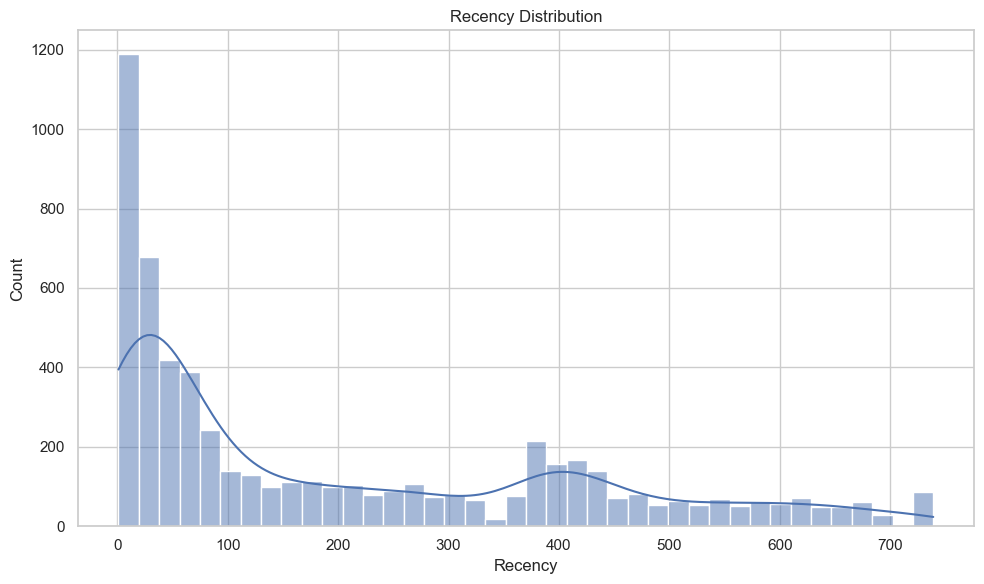

Saved: plots/frequency_distribution.png


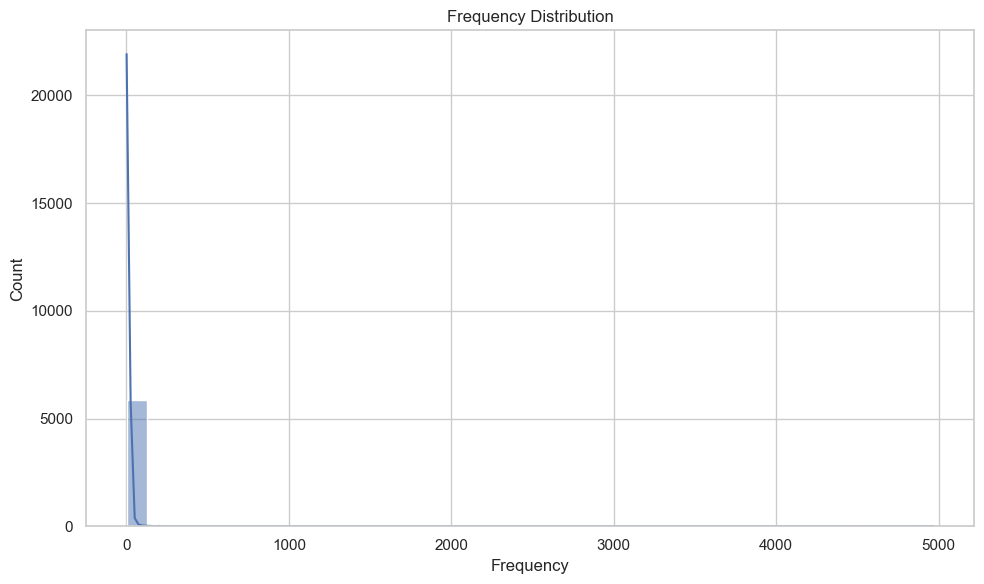

Saved: plots/monetary_distribution.png


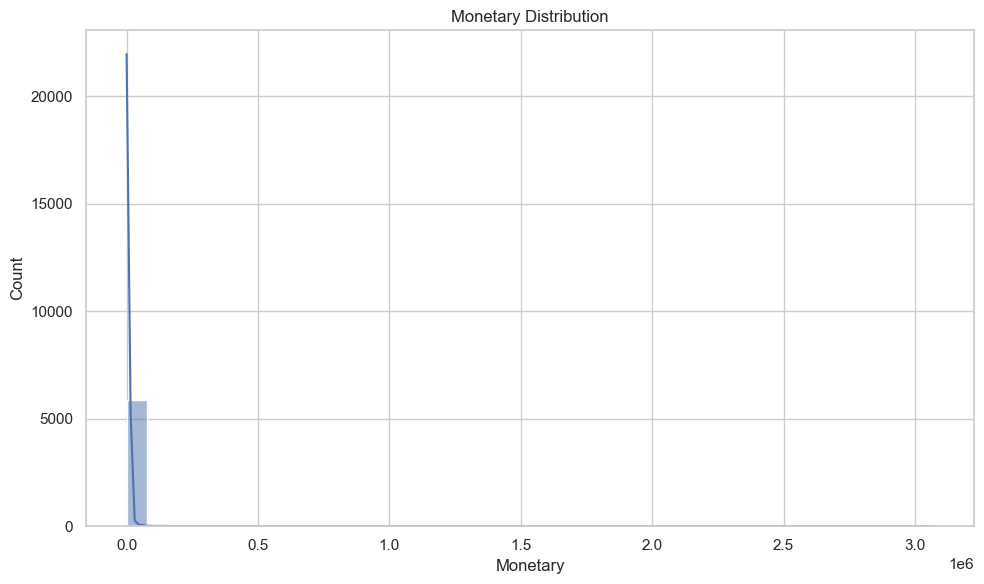

Saved: plots/recency_by_cluster.png


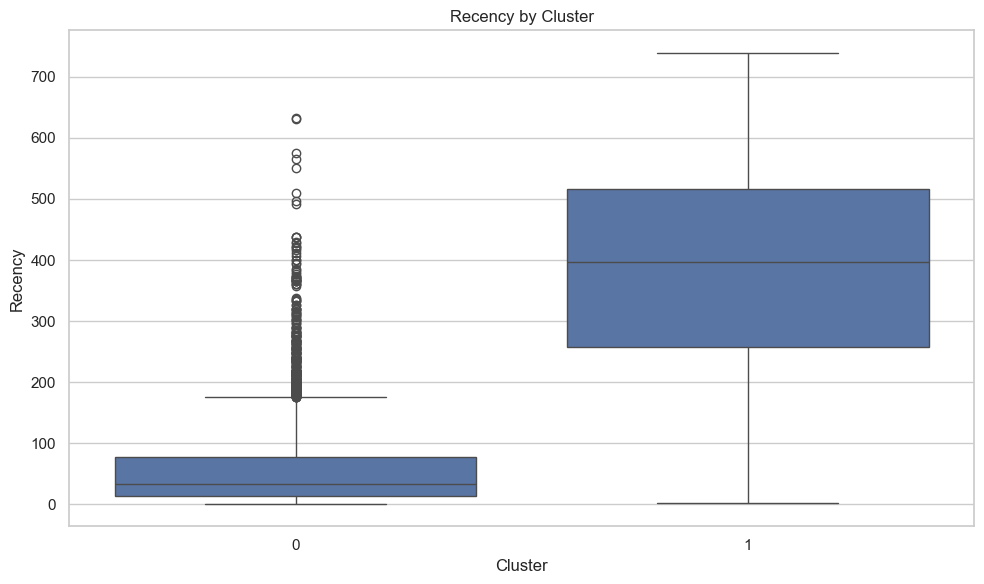

Saved: plots/frequency_by_cluster.png


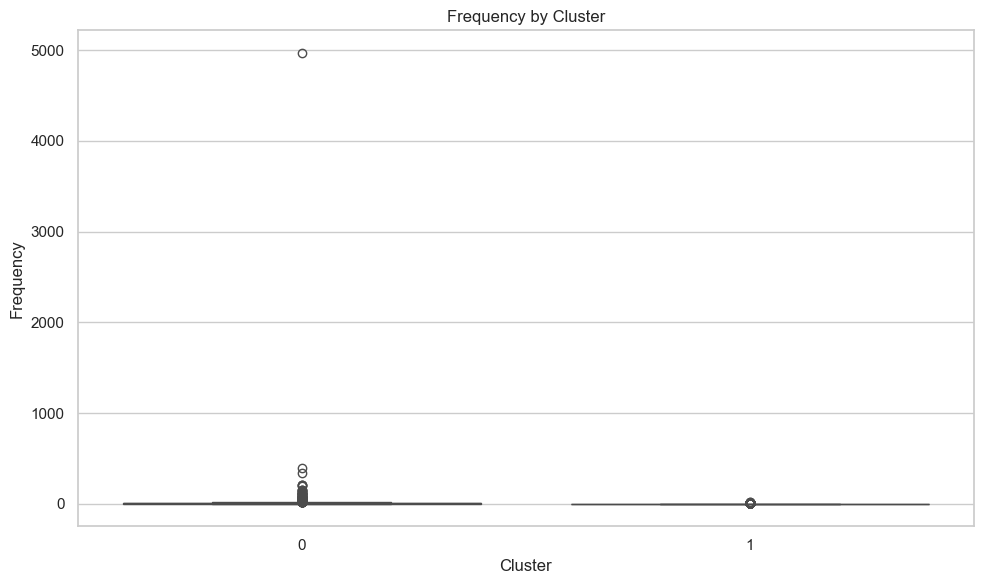

ValueError: Could not interpret value `Frequency` for `x`. Value is a string, but `data` was not passed.

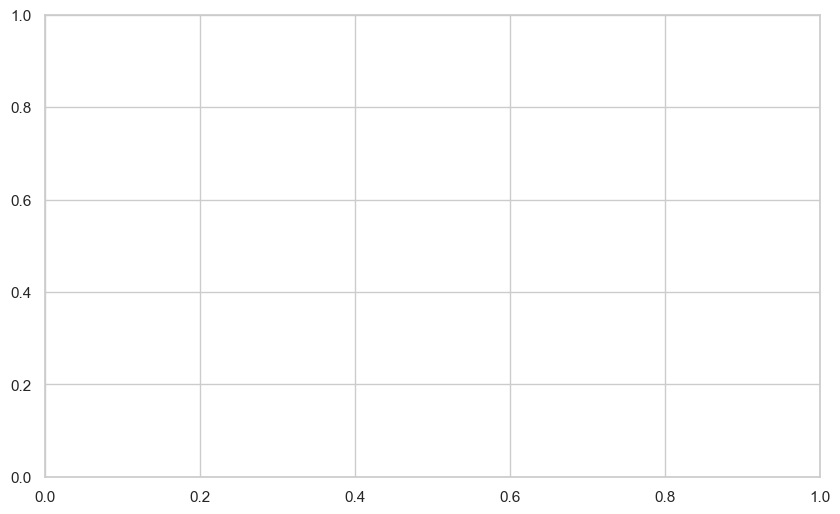

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("customers_with_clusters.csv")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# 1. Cluster Count
fig, ax = plt.subplots()
sns.countplot(x=df["Cluster"], ax=ax)
ax.set_title("Cluster Counts")
save_and_show(fig, "cluster_count.png")

# 2. Recency Distribution
fig, ax = plt.subplots()
sns.histplot(df["Recency"], kde=True, bins=40, ax=ax)
ax.set_title("Recency Distribution")
save_and_show(fig, "recency_distribution.png")

# 3. Frequency Distribution
fig, ax = plt.subplots()
sns.histplot(df["Frequency"], kde=True, bins=40, ax=ax)
ax.set_title("Frequency Distribution")
save_and_show(fig, "frequency_distribution.png")

# 4. Monetary Distribution
fig, ax = plt.subplots()
sns.histplot(df["Monetary"], kde=True, bins=40, ax=ax)
ax.set_title("Monetary Distribution")
save_and_show(fig, "monetary_distribution.png")

# 5. Recency by Cluster
fig, ax = plt.subplots()
sns.boxplot(x="Cluster", y="Recency", data=df, ax=ax)
ax.set_title("Recency by Cluster")
save_and_show(fig, "recency_by_cluster.png")

# 6. Frequency by Cluster
fig, ax = plt.subplots()
sns.boxplot(x="Cluster", y="Frequency", data=df, ax=ax)
ax.set_title("Frequency by Cluster")
save_and_show(fig, "frequency_by_cluster.png")

# 7. Monetary vs Frequency
fig, ax = plt.subplots()
sns.scatterplot(x="Frequency", y="Monetary", hue="Cluster", palette="tab10", s=20, ax=ax)
ax.set_title("Monetary vs Frequency")
save_and_show(fig, "monetary_vs_frequency.png")

# 8. Correlation Heatmap
fig, ax = plt.subplots()
sns.heatmap(df[["Recency","Frequency","Monetary"]].corr(), annot=True, cmap="coolwarm", ax=ax)
ax.set_title("RFM Correlation")
save_and_show(fig, "correlation_heatmap.png")

# 9. Monetary by Cluster
fig, ax = plt.subplots()
sns.boxplot(x="Cluster", y="Monetary", data=df, ax=ax)
ax.set_title("Monetary by Cluster")
save_and_show(fig, "monetary_by_cluster.png")

# 10. Pairplot
pair = sns.pairplot(df[["Recency","Frequency","Monetary","Cluster"]], hue="Cluster", palette="tab10")
pair.fig.suptitle("RFM Pairplot", y=1.02)
pair.savefig("plots/rfm_pairplot.png", dpi=150)
print("Saved: plots/rfm_pairplot.png")
plt.show()
